In [4]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 4.2 MB/s eta 0:00:36
   ---------------------------------------- 1.3/150.0 MB 4.0 MB/s eta 0:00:38
    --------------------------------------- 2.4/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 3.1/150.0 MB 4.3 MB/s eta 0:00:35
   - -------------------------------------- 4.2/150.0 MB 4.4 MB/s eta 0:00:33
   - -------------------------------------- 4.7/150.0 MB 4.1 MB/s eta 0:00:36
   - -------------------------------------- 5.8/150.0 MB 4.2 MB/s eta 0:00:34
   - -------------------------------------- 6.8/150.0 MB 4.3 MB/s eta 0:00:34
   -- ------------------------------------- 7.9/150.0 MB 4.4 MB/s eta 0:00:33
   -- ------------------------------------- 8.7/150.0 MB 4.5 MB/s eta 0:00:32
   -- ------------------------------------- 9.4/150.0 MB 4.3 MB/s eta 0:00:33
   -- ------------------------------------- 10.5/150.0 MB 4.4 MB/s eta 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


=== 🚀 STARTING PIPELINE ===

📥 Loading price data...

🧠 Loading sentiment data...
⚠️ Removed 1 rows with invalid dates
Loaded 99 sentiment records from 2025-06-03 to 2025-06-04

🛠️ Creating features...

=== MERGE DEBUG ===
Price dates: 2025-02-13 00:00:00 to 2025-05-24 00:00:00
Sentiment dates: 2025-06-03 00:00:00 to 2025-06-04 00:00:00

=== MERGED COLUMNS ===
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'title', 'publishedAt', 'sent_pos', 'sent_neg', 'sent_neutral', 'date']

=== SENTIMENT VALUES IN MERGED DATA ===
        Date  sent_pos  sent_neg  sent_neutral
0 2025-02-13       NaN       NaN           NaN
1 2025-02-14       NaN       NaN           NaN
2 2025-02-15       NaN       NaN           NaN
3 2025-02-16       NaN       NaN           NaN
4 2025-02-17       NaN       NaN           NaN
✅ Generated 51 samples with 17 features each

🔍 Running walk-forward backtest...

=== MODEL ACCURACY METRICS ===
Average Accuracy: 73.33%
Average Precision: 87.50%
Average Recall: 68.75%
Aver

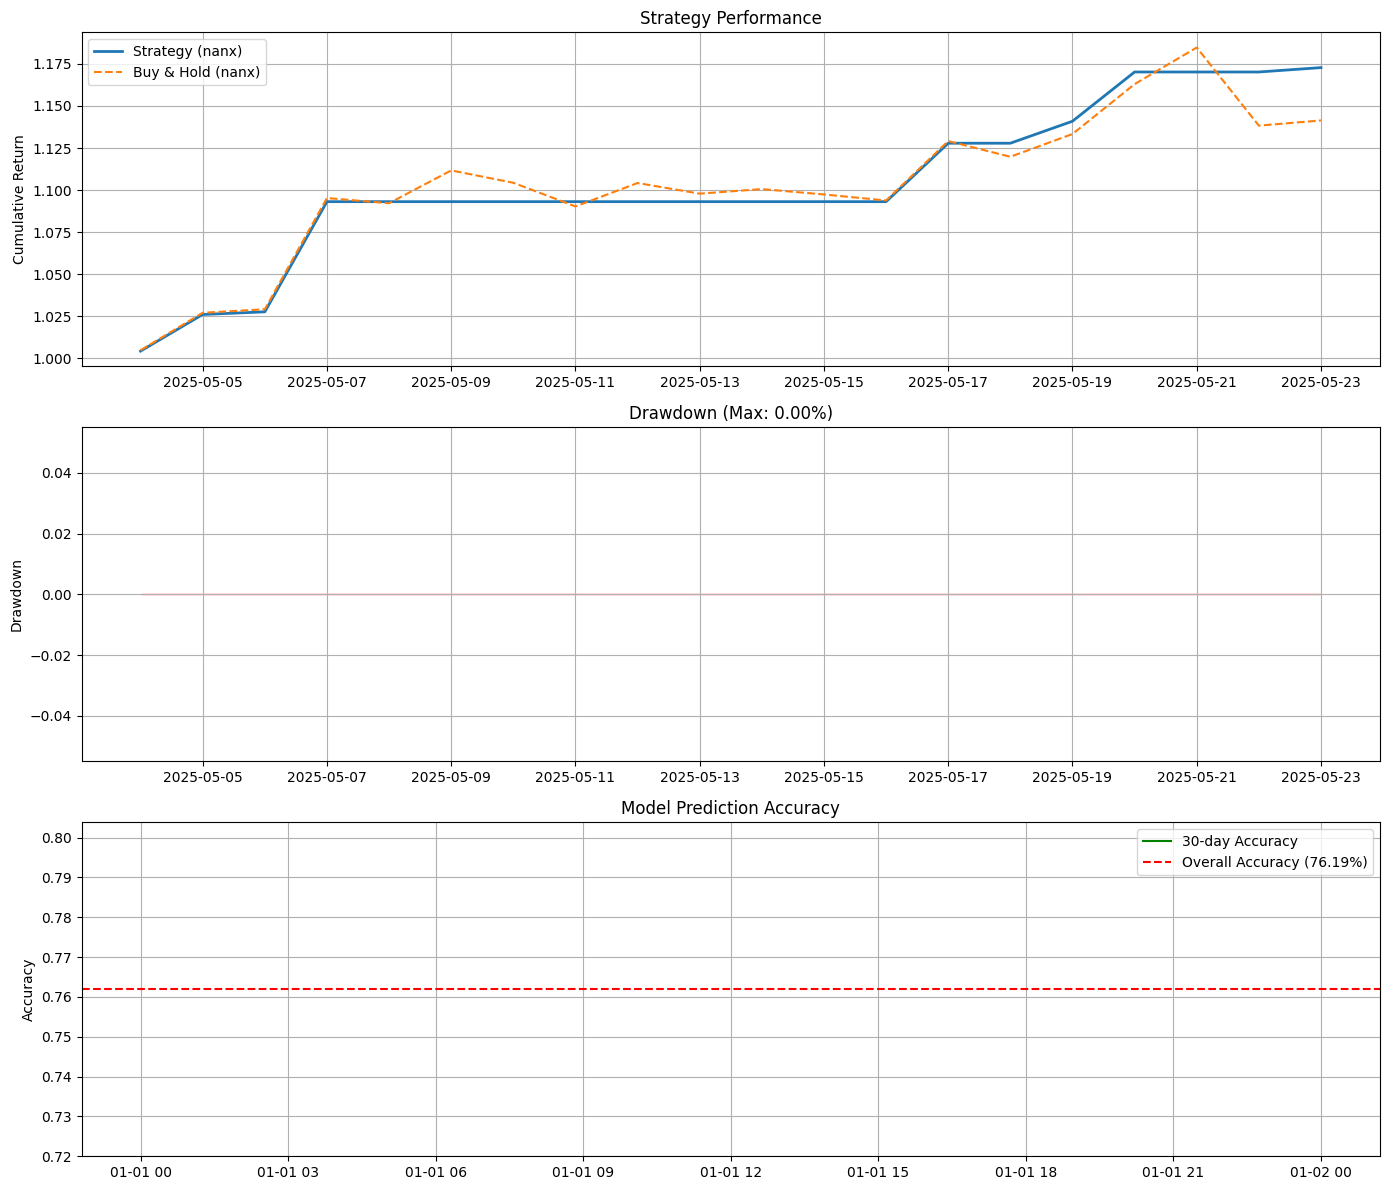


=== COMPREHENSIVE PERFORMANCE METRICS ===
Accuracy: 76.19%
Precision: 88.89%
Recall: 66.67%
Win Rate: 38.10%
Sharpe Ratio: 9.53
Max Drawdown: 0.00%
Strategy Return: nanx
Buy & Hold Return: nanx


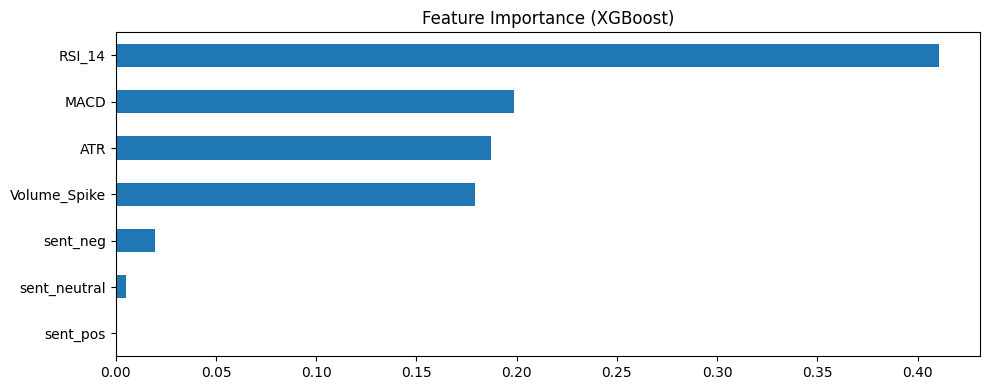


✅ Pipeline completed successfully!


In [ ]:
import pandas as pd
import ta
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from binance.client import Client
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# load in tha data
def get_price_data(symbol='BTCUSDT', days=360):
    """Fetch price data with caching and validation"""
    cache_file = 'price_data.csv'
    try:
        if os.path.exists(cache_file):
            df = pd.read_csv(cache_file)
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df = df.dropna(subset=['Date'])
            return df
        
        print(f"Downloading {days} days of {symbol} data...")
        client = Client()
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=Client.KLINE_INTERVAL_1DAY,
            limit=days
        )
        
        df = pd.DataFrame(klines, columns=[
            'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close time', 'Quote volume', 'Trades',
            'Taker buy volume', 'Taker quote volume', 'Ignore'
        ])
        
        df['Date'] = pd.to_datetime(df['Open time'], unit='ms').dt.normalize()
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_cols] = df[numeric_cols].astype(float)
        df = df[['Date'] + numeric_cols]
        df.to_csv(cache_file, index=False)
        return df
        
    except Exception as e:
        print(f" Price data error: {str(e)}")
        raise

def load_sentiment_data():
    """Load and validate sentiment data"""
    if not os.path.exists('news_with_sentiment.csv'):
        raise FileNotFoundError("Sentiment data not found. Run sentiment analysis first.")
    
    df = pd.read_csv('news_with_sentiment.csv')
    
    for col in ['sent_pos', 'sent_neg', 'sent_neutral']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    df['date'] = pd.to_datetime(df['publishedAt'], errors='coerce')
    initial_count = len(df)
    df = df.dropna(subset=['date'])
    df['date'] = df['date'].dt.normalize()
    
    if len(df) < initial_count:
        print(f"Removed {initial_count - len(df)} rows with invalid dates")
    print(f"Loaded {len(df)} sentiment records from {df['date'].min().date()} to {df['date'].max().date()}")
    return df

#feature engineering
def create_features(price_df, sentiment_df):
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], errors='coerce').dt.normalize()
        price_df = price_df.dropna(subset=['Date'])

        print("\n=== MERGE DEBUG ===")
        print(f"Price dates: {price_df['Date'].min()} to {price_df['Date'].max()}")
        print(f"Sentiment dates: {sentiment_df['date'].min()} to {sentiment_df['date'].max()}")
        
        merged = pd.merge_asof(
            price_df.sort_values('Date'),
            sentiment_df.sort_values('date'),
            left_on='Date',
            right_on='date',
            direction='forward',
            tolerance=pd.Timedelta('60d')
        )
        print("\n=== MERGED COLUMNS ===")
        print(merged.columns.tolist())
        
        print("\n=== SENTIMENT VALUES IN MERGED DATA ===")
        print(merged[['Date', 'sent_pos', 'sent_neg', 'sent_neutral']].head())
                
        for col in ['sent_pos', 'sent_neg', 'sent_neutral']:
            merged[col] = merged[col].fillna(0)
        
        # Technical indicators
        merged['RSI_14'] = ta.momentum.RSIIndicator(merged['Close'], window=14).rsi()
        merged['MACD'] = ta.trend.MACD(merged['Close']).macd()
        merged['Volume_Spike'] = merged['Volume'] / merged['Volume'].rolling(5).mean() - 1
        merged['ATR'] = ta.volatility.AverageTrueRange(
            merged['High'], merged['Low'], merged['Close'], window=14
        ).average_true_range()
        
        # Target: 1 if next day's return is positive, 0 otherwise
        merged['Target'] = (merged['Close'].shift(-1) > merged['Close']).astype(int)
        
        return merged.dropna()
    
    except Exception as e:
        print(f"❌ Feature engineering failed: {str(e)}")
        raise

#training/bcaktesting
def walk_forward_train(features_df, initial_train_size=100, retrain_every=30):
    """Walk-forward training with accuracy tracking"""
    if len(features_df) < initial_train_size + retrain_every:
        raise ValueError(f"Need at least {initial_train_size + retrain_every} samples, got {len(features_df)}")
    
    # Define all possible features
    all_feature_cols = ['RSI_14', 'MACD', 'Volume_Spike', 'sent_pos', 'sent_neg', 'sent_neutral', 'ATR']
    
    # Select only features that exist in the dataframe
    feature_cols = [col for col in all_feature_cols if col in features_df.columns]
    
    results = []
    models = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for i in range(initial_train_size, len(features_df), retrain_every):
        train = features_df.iloc[max(0, i-initial_train_size):i]
        test = features_df.iloc[i:min(i+retrain_every, len(features_df))]
        
        if len(test) == 0 or train['Target'].nunique() < 2:
            continue
            
        try:
            # Feature scaling
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train[feature_cols])
            X_test = scaler.transform(test[feature_cols])
            y_train = train['Target']
            y_test = test['Target']
            
            # Model training
            model = XGBClassifier(
                n_estimators=150,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric=['error', 'logloss']
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            # Predictions
            test_preds = model.predict(X_test)
            test_probs = model.predict_proba(X_test)[:, 1]
            
            # Store results
            test_results = test[['Date', 'Close']].copy()
            test_results['Prediction'] = test_preds
            test_results['Probability'] = test_probs
            test_results['Actual'] = y_test.values
            test_results['Next_Close'] = features_df['Close'].shift(-1).iloc[i:i+len(test)].values
            results.append(test_results)
            models.append(model)
            
            # Calculate metrics
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
            accuracy_scores.append(accuracy_score(y_test, test_preds))
            precision_scores.append(precision_score(y_test, test_preds))
            recall_scores.append(recall_score(y_test, test_preds))
            f1_scores.append(f1_score(y_test, test_preds))
            
        except Exception as e:
            print(f"Fold {i} failed: {str(e)}")
            continue
    
    if not results:
        raise ValueError("No valid backtest folds completed")
    
    # Print accuracy statistics
    print("\n=== MODEL ACCURACY METRICS ===")
    print(f"Average Accuracy: {np.mean(accuracy_scores):.2%}")
    print(f"Average Precision: {np.mean(precision_scores):.2%}")
    print(f"Average Recall: {np.mean(recall_scores):.2%}")
    print(f"Average F1 Score: {np.mean(f1_scores):.2%}")
    print(f"\nFold-by-fold Accuracy Scores:")
    for i, acc in enumerate(accuracy_scores):
        print(f"Fold {i+1}: {acc:.2%}")
    
    return pd.concat(results), models, feature_cols  # Now returning feature_cols too

#metric calc
def calculate_strategy_metrics(results_df, fee_pct=0.0005):
    """Enhanced metrics with accuracy reporting"""
    df = results_df.copy()
    
    # Trading returns
    df['Strategy_Return'] = np.where(
        df['Prediction'] == 1,
        (df['Next_Close'] / df['Close'] - 1) - fee_pct,
        0
    )
    df['BH_Return'] = (df['Next_Close'] / df['Close'] - 1)
    
    # Cumulative returns
    df['Cum_Strategy'] = (1 + df['Strategy_Return']).cumprod()
    df['Cum_BH'] = (1 + df['BH_Return']).cumprod()
    
    # Accuracy metrics
    accuracy = (df['Prediction'] == df['Actual']).mean()
    precision = (df[(df['Prediction'] == 1) & (df['Actual'] == 1)].shape[0] / 
                max(1, df[df['Prediction'] == 1].shape[0]))
    recall = (df[(df['Prediction'] == 1) & (df['Actual'] == 1)].shape[0] / 
             max(1, df[df['Actual'] == 1].shape[0]))
    
    # Risk metrics
    sharpe = (df['Strategy_Return'].mean() / df['Strategy_Return'].std()) * np.sqrt(365)
    max_dd = (df['Cum_Strategy'].cummax() - df['Cum_Strategy']).max()
    
    return {
        'df': df,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'total_return': df['Cum_Strategy'].iloc[-1],
            'bh_return': df['Cum_BH'].iloc[-1],
            'win_rate': (df['Strategy_Return'] > 0).mean()
        }
    }

#results ploting
def plot_backtest_results(results):
    """Enhanced visualization with accuracy"""
    df = results['df']
    metrics = results['metrics']
    
    plt.figure(figsize=(14, 12))
    
    # Cumulative Returns
    plt.subplot(3, 1, 1)
    plt.plot(df['Date'], df['Cum_Strategy'], label=f'Strategy ({metrics["total_return"]:.2f}x)', linewidth=2)
    plt.plot(df['Date'], df['Cum_BH'], label=f'Buy & Hold ({metrics["bh_return"]:.2f}x)', linestyle='--')
    plt.title('Strategy Performance')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    # Drawdown
    plt.subplot(3, 1, 2)
    drawdown = (df['Cum_Strategy'].cummax() - df['Cum_Strategy'])
    plt.fill_between(df['Date'], drawdown, color='red', alpha=0.3)
    plt.title(f'Drawdown (Max: {metrics["max_drawdown"]:.2%})')
    plt.ylabel('Drawdown')
    plt.grid(True)
    
    # Prediction Accuracy
    plt.subplot(3, 1, 3)
    correct = df['Prediction'] == df['Actual']
    rolling_acc = correct.rolling(30).mean()
    plt.plot(df['Date'], rolling_acc, label='30-day Accuracy', color='green')
    plt.axhline(metrics['accuracy'], color='red', linestyle='--', label=f'Overall Accuracy ({metrics["accuracy"]:.2%})')
    plt.title('Model Prediction Accuracy')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print full metrics
    print("\n=== COMPREHENSIVE PERFORMANCE METRICS ===")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"Precision: {metrics['precision']:.2%}")
    print(f"Recall: {metrics['recall']:.2%}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"Strategy Return: {metrics['total_return']:.2f}x")
    print(f"Buy & Hold Return: {metrics['bh_return']:.2f}x")

# main
def main():
    print("=== STARTING PIPELINE ===")
    try:
        # === Step 1: Load Data ===
        print("\nLoading price data")
        price_data = get_price_data(days=365)
        
        print("\nLoading sentiment data")
        sentiment_data = load_sentiment_data()

        # === Step 2: Feature Engineering ===
        features = create_features(price_data, sentiment_data)
        print(f"Generated {len(features)} samples with {len(features.columns)} features each")

        # pd.set_option('display.max_columns', None)
        # pd.set_option('display.max_rows', None)
        # print("\n=== FULL TRAINING DATA ===")
        # print(features)

        # === Step 3: Walk-Forward Backtest ===
        print("\n🔍 Running walk-forward backtest...")
        backtest_results, models, feature_cols = walk_forward_train(  # Now receiving feature_cols
            features,
            initial_train_size=40,
            retrain_every=20
        )
        performance = calculate_strategy_metrics(backtest_results)
        
        # === Step 4: Analyze Results ===
        plot_backtest_results(performance)
        
        # Show feature importance from last model - using the actual feature_cols used
        plt.figure(figsize=(10,4))
        pd.Series(models[-1].feature_importances_, index=feature_cols).sort_values().plot.barh()
        plt.title('Feature Importance (Latest Model)')
        plt.show()

        print("\nPipeline completed successfully!")

    except Exception as e:
        print(f"\n Pipeline failed: {str(e)}")

if __name__ == "__main__":
    main()